In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import time

import cv2
import torch
import numpy as np
import nibabel as nib
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from skimage import measure


class ModelSegmentationManager:

    def __init__(self):
        self.n_cls = 1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Преобразования для входного изображения
        self.trans = A.Compose([A.Resize(256, 256), ToTensorV2()])
        self.model = None

    def upload_model(self):
        self.model = self.__load_model()
        print('✅ Successfully upload model')

    def __load_model(self):
        model = smp.DeepLabV3Plus(classes=self.n_cls, in_channels=1)
        try:
            model.load_state_dict(torch.load('/content/drive/MyDrive/model1.pth', map_location=self.device))
        except FileNotFoundError:
            raise RuntimeError("Model file not found")
        model.to(self.device)
        model.eval()
        return model

    @staticmethod
    def __postprocess_mask(mask: torch.Tensor) -> torch.Tensor:
        """Удаляет шумы из бинарной маски с помощью морфологических операций."""
        mask_np = mask.squeeze(0).cpu().numpy().astype(np.uint8) * 255

        # Удаляем мелкие шумы (открытие)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)

        # Заполняем мелкие дыры (закрытие)
        mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_CLOSE, kernel)

        return torch.from_numpy(mask_np / 255).unsqueeze(0).to(mask.device)

    @staticmethod
    def preprocess_im(im):
        if torch.is_tensor(im):
            im = im.detach().cpu().numpy()
        im = np.clip(im, 0, None)
        max_val = np.max(im) or 1
        return im / max_val

    @staticmethod
    def read_nii(file_bytes):

        file_stream = io.BytesIO(file_bytes)
        file_holder = nib.FileHolder(fileobj=file_stream)
        nii_image = nib.Nifti1Image.from_file_map({'header': file_holder, 'image': file_holder})

        return nii_image.get_fdata().astype('float32')

    def apply_transformations(self, im):
        transformed = self.trans(image=im)
        return transformed["image"].unsqueeze(0).to(self.device, dtype=torch.float32)  # Сразу отправляем на GPU

    @staticmethod
    def __find_contours(mask):
        mask = mask.squeeze(0).cpu().numpy().astype(np.uint8) * 255  # CPU + бинаризация
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contour_mask = np.zeros_like(mask)
        if contours:
            cv2.drawContours(contour_mask, contours, -1, 255, thickness=1)

        return contour_mask

    @staticmethod
    def __display_results(image, liver_contour):
        image_np = image.squeeze(0).cpu().numpy()  # Переводим в numpy заранее
        fig, ax = plt.subplots(figsize=(image_np.shape[1] / 100, image_np.shape[0] / 100), dpi=100)

        ax.axis("off")
        ax.imshow(image_np, cmap="gray")
        ax.contour(liver_contour, colors="r", linewidths=0.8)

        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0, transparent=True)
        plt.close(fig)
        buf.seek(0)

        return buf.getvalue()

    def __draw_with_user_contours(self, image_slice, user_contours):
        """
        Рисует изображение с множеством пользовательских контуров.
        :param image_slice: NumPy-массив одного среза (H x W)
        :param user_contours: Список контуров [[ [x, y], [x2, y2], ... ], [ ... ], ...]
        :return: PNG-картинка как bytes
        """

        # Удаляем лишнюю размерность, если есть
        if image_slice.ndim == 3 and image_slice.shape[0] == 1:
            image_slice = image_slice.squeeze(0)

        if image_slice.ndim != 2:
            raise ValueError(f"Expected 2D image slice, got shape {image_slice.shape}")

        image_norm = self.preprocess_im(image_slice)
        image_np = (image_norm * 255).astype(np.uint8)

        mask_shape = image_np.shape
        contour_mask = np.zeros((mask_shape[0], mask_shape[1], 3), dtype=np.uint8)

        for contour in user_contours:
            if len(contour) < 2:
                continue
            points = np.array(contour, dtype=np.int32).reshape((-1, 1, 2))
            cv2.polylines(contour_mask, [points], isClosed=True, color=(255, 0, 0), thickness=1)

        image_color = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)
        combined = cv2.addWeighted(image_color, 1.0, contour_mask, 1.0, 0)

        fig, ax = plt.subplots(figsize=(combined.shape[1] / 100, combined.shape[0] / 100), dpi=100)
        ax.axis("off")
        ax.imshow(combined)

        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0, transparent=True)
        plt.close(fig)
        buf.seek(0)

        return buf.getvalue()

    def pred_image(self, image_volume, num_images):
        image = image_volume[:, :, num_images]
        image = self.apply_transformations(image)
        return image

    def get_result_contours(self, image):
        with torch.no_grad():
            y_pred = torch.sigmoid(self.model(image)) > 0.7
        contour = self.__find_contours(y_pred[0])
        contours = measure.find_contours(contour, level=0.7)
        mass_check = set()
        contours_list = []
        for contour in contours:
            new_counter = []
            for point in contour:
                tupl = (round(point[1], 1), round(point[0], 1))
                if tupl not in mass_check:
                    mass_check.add(tupl)
                    new_counter.append(list(tupl))
            contours_list.append(new_counter)

        # contours_list = [[[int(point[1]), int(point[0])] for point in contour] for contour in contours]
        return contours_list

    def create_photo_with_contours(self, image, contours_list):
        result_img = self.__draw_with_user_contours(image[0], contours_list)
        return result_img

    def get_result(self, image_volume, num_images):
        time_start1 = time.time()
        image = image_volume[:, :, num_images]
        image = self.apply_transformations(image)

        with torch.no_grad():
            y_pred = torch.sigmoid(self.model(image)) > 0.9  # 0.5
            # y_pred = self.__postprocess_mask(y_pred)  # Очищаем маску  # Прямо в одном вызове

        contour = self.__find_contours(y_pred[0])
        print(time.time() - time_start1)

        def mask_to_contour(mask: np.ndarray):
            contours = measure.find_contours(mask, level=0.7)
            # Переводим в формат [[x, y], [x, y], ...]
            contours_list = [[[int(point[1]), int(point[0])] for point in contour] for contour in contours]
            return contours_list

        new_contour = mask_to_contour(contour)
        time_start = time.time()
        result_img = self.__display_results(image[0], contour)
        result_img = self.__draw_with_user_contours(image[0], new_contour)
        print(time.time() - time_start)

        return result_img, new_contour

    @staticmethod
    def get_photo(image):
        image_np = image[0].squeeze(0).cpu().numpy()
        fig, ax = plt.subplots(figsize=(image_np.shape[1] / 100, image_np.shape[0] / 100), dpi=100)

        ax.axis("off")
        ax.imshow(image_np, cmap="gray")

        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0, transparent=True)
        plt.close(fig)
        buf.seek(0)
        return buf.getvalue()


modelManager = ModelSegmentationManager()

✅ Successfully upload model
Модель успешно загружена
Найдено 376 DICOM файлов
Обработка 1/376: /content/drive/MyDrive/ART_2/IM-0013-0001.dcm
0.016735553741455078
0.1960439682006836
Результаты сохранены: dicom_predictions/IM-0013-0001_prediction.png
Обработка 2/376: /content/drive/MyDrive/ART_2/IM-0013-0002.dcm
0.018877744674682617
0.2598838806152344
Результаты сохранены: dicom_predictions/IM-0013-0002_prediction.png
Обработка 3/376: /content/drive/MyDrive/ART_2/IM-0013-0003.dcm
0.0363922119140625
0.27337217330932617
Результаты сохранены: dicom_predictions/IM-0013-0003_prediction.png
Обработка 4/376: /content/drive/MyDrive/ART_2/IM-0013-0004.dcm
0.015190839767456055
0.12699556350708008
Результаты сохранены: dicom_predictions/IM-0013-0004_prediction.png
Обработка 5/376: /content/drive/MyDrive/ART_2/IM-0013-0005.dcm
0.014868497848510742
0.12008213996887207
Результаты сохранены: dicom_predictions/IM-0013-0005_prediction.png
Обработка 6/376: /content/drive/MyDrive/ART_2/IM-0013-0006.dcm
0.0

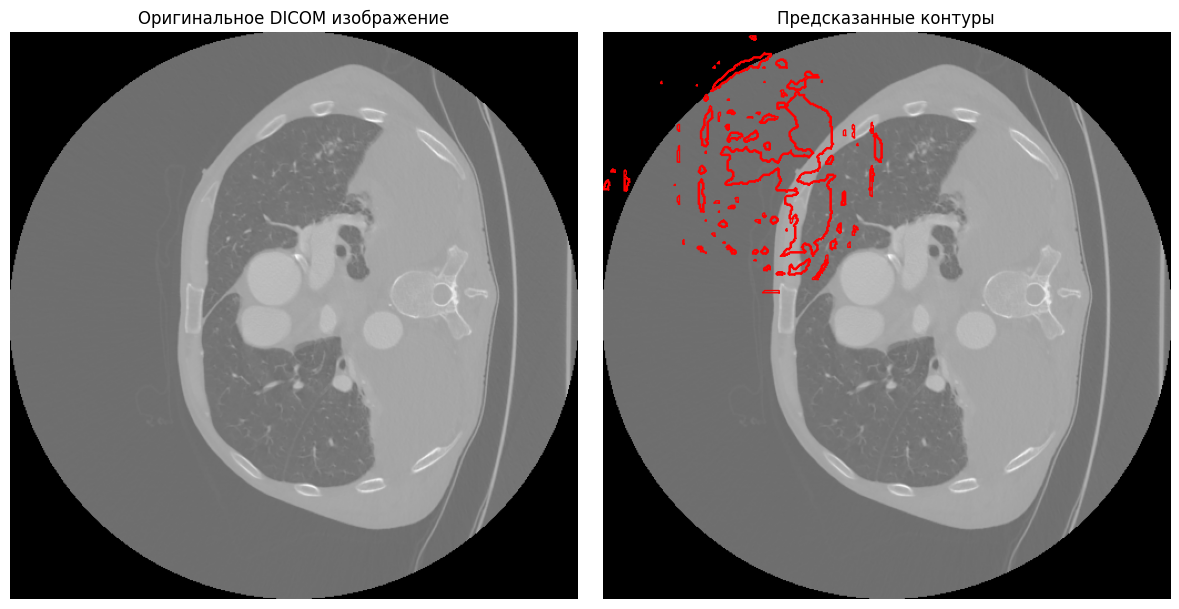

In [ ]:
import torch
import pydicom
import numpy as np
import io
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt


class DICOMDataset(Dataset):
    def __init__(self, root_dir):
        self.dcm_paths = sorted(glob.glob(f"{root_dir}/*.dcm"))
        self.manager = ModelSegmentationManager()
        self.manager.upload_model()  # Загружаем модель один раз

    def __len__(self):
        return len(self.dcm_paths)

    def __getitem__(self, idx):
        dcm_path = self.dcm_paths[idx]

        # Читаем DICOM файл
        dicom = pydicom.dcmread(dcm_path)
        image = dicom.pixel_array.astype(np.float32)

        # Транспонируем как в NIfTI
        image = image.transpose(1, 0)

        return image, dcm_path

def predict_dicom_single_slice(manager, dicom_path):
    """Предсказание для одного DICOM файла"""
    # Читаем DICOM
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array.astype(np.float32)

    # Транспонируем как в NIfTI
    image = image.transpose(1, 0)

    # Создаем псевдо-объем с одним срезом для совместимости с вашим кодом
    image_volume = np.expand_dims(image, axis=2)  # shape: (H, W, 1)

    # Используем ваш существующий метод для предсказания
    result_img, contours = manager.get_result(image_volume, 0)

    return result_img, contours, image

def predict_dicom_batch(manager, dicom_dir):
    """Предсказание для всех DICOM файлов в директории"""
    dcm_paths = sorted(glob.glob(f"{dicom_dir}/*.dcm"))
    results = {}

    print(f"Найдено {len(dcm_paths)} DICOM файлов")

    for i, dcm_path in enumerate(dcm_paths):
        print(f"Обработка {i+1}/{len(dcm_paths)}: {dcm_path}")

        try:
            if i > 10:
              break

            result_img, contours, original_image = predict_dicom_single_slice(manager, dcm_path)

            results[dcm_path] = {
                'contours': contours,
                'visualization': result_img,
                'original_image': original_image
            }

            # Сохраняем результат
            save_prediction_result(dcm_path, result_img, contours)

        except Exception as e:
            print(f"Ошибка при обработке {dcm_path}: {e}")

    return results

def save_prediction_result(dicom_path, result_img, contours):
    """Сохранение результатов предсказания"""
    import os

    base_name = os.path.basename(dicom_path).replace('.dcm', '')
    output_dir = "dicom_predictions"
    os.makedirs(output_dir, exist_ok=True)

    # Сохраняем визуализацию
    viz_path = os.path.join(output_dir, f"{base_name}_prediction.png")
    with open(viz_path, 'wb') as f:
        f.write(result_img)

    # Сохраняем контуры как numpy
    contour_path = os.path.join(output_dir, f"{base_name}_contours.npy")
    np.save(contour_path, np.array(contours, dtype=object))

    print(f"Результаты сохранены: {viz_path}")

def visualize_dicom_prediction(original_image, contours, save_path=None):
    """Визуализация предсказания для DICOM"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Оригинальное изображение
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Оригинальное DICOM изображение')
    axes[0].axis('off')

    # Изображение с контурами
    axes[1].imshow(original_image, cmap='gray')
    for contour in contours:
        if len(contour) > 1:
            contour_array = np.array(contour)
            axes[1].plot(contour_array[:, 0], contour_array[:, 1], 'r-', linewidth=1)
    axes[1].set_title('Предсказанные контуры')
    axes[1].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

# Основная функция
def main():
    # Инициализируем менеджер
    manager = ModelSegmentationManager()
    manager.upload_model()

    print("Модель успешно загружена")

    # Путь к DICOM файлам
    dicom_dir = "/content/drive/MyDrive/ART_2"  # Укажите правильный путь

    # Предсказание для всех DICOM файлов
    results = predict_dicom_batch(manager, dicom_dir)

    print(f"\nОбработано {len(results)} DICOM файлов")

    # Демонстрация результатов для первого файла
    if results:
        first_key = list(results.keys())[0]
        result = results[first_key]

        print(f"\nДемонстрация для: {first_key}")
        print(f"Найдено контуров: {len(result['contours'])}")

        # Визуализация
        visualize_dicom_prediction(
            result['original_image'],
            result['contours'],
            save_path="dicom_prediction_demo.png"
        )

# Альтернативный вариант для работы с отдельными файлами
def process_single_dicom(dicom_path):
    """Обработка одного DICOM файла"""
    manager = ModelSegmentationManager()
    manager.upload_model()

    result_img, contours, original_image = predict_dicom_single_slice(manager, dicom_path)

    # Визуализация
    visualize_dicom_prediction(original_image, contours)

    return result_img, contours

if __name__ == "__main__":
    main()

In [ ]:
# Установка необходимых библиотек
!pip install segmentation_models_pytorch albumentations nibabel pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 103.9 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import nibabel as nib
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import random
import time
import cv2

Датасет: [3D Liver segmentation](https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
root = "/content/drive/MyDrive/Task03_Liver_rs"

# Получение данных о датасете

In [ ]:
im_paths = glob(f"{root}/imagesTr/*.nii")
gt_paths = glob(f"{root}/labelsTr/*.nii")
print(f'Количество стоковых nii файлов: {len(im_paths)}')
print(f'Количество размеченных файлов: {len(gt_paths)}')

Количество стоковых nii файлов: 123
Количество размеченных файлов: 123


In [ ]:
im_total_counter = 0
gt_total_counter = 0
for i in range(len(im_paths)):

  print(f'{i}/{len(im_paths)}')

  im_total_counter += len(nib.load(im_paths[i]).get_fdata().transpose(2, 1, 0))
  gt_total_counter += len(nib.load(gt_paths[i]).get_fdata().transpose(2, 1, 0))

  if i == len(im_paths):
    print(f'{i}/{len(im_paths)}')

0/123
1/123
2/123
3/123
4/123
5/123
6/123
7/123
8/123
9/123
10/123
11/123
12/123
13/123
14/123
15/123
16/123
17/123
18/123
19/123
20/123
21/123
22/123
23/123
24/123
25/123
26/123
27/123
28/123
29/123
30/123
31/123
32/123
33/123
34/123
35/123
36/123
37/123
38/123
39/123
40/123
41/123
42/123
43/123
44/123
45/123
46/123
47/123
48/123
49/123
50/123
51/123
52/123
53/123
54/123
55/123
56/123
57/123
58/123
59/123
60/123
61/123
62/123
63/123
64/123
65/123
66/123
67/123
68/123
69/123
70/123
71/123
72/123
73/123
74/123
75/123
76/123
77/123
78/123
79/123
80/123
81/123
82/123
83/123
84/123
85/123
86/123
87/123
88/123
89/123
90/123
91/123
92/123
93/123
94/123
95/123
96/123
97/123
98/123
99/123
100/123
101/123
102/123
103/123
104/123
105/123
106/123
107/123
108/123
109/123
110/123
111/123
112/123
113/123
114/123
115/123
116/123
117/123
118/123
119/123
120/123
121/123
122/123


In [ ]:
print(f'В среднем в стоковых nii файлах {round(im_total_counter / len(im_paths), 2)} срезов. Всего {im_total_counter} срезов')
print(f'В среднем в размеченных файлах {round(gt_total_counter / len(gt_paths), 2)} срезов. Всего {gt_total_counter} срезов')

В среднем в стоковых nii файлах 159.38 срезов. Всего 19604 срезов
В среднем в размеченных файлах 159.38 срезов. Всего 19604 срезов


# Предобработка входных данных

In [ ]:
class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations=None):
        im_nii_paths = sorted(glob(f"{root}/imagesTr/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/labelsTr/*.nii"))

        self.ims = []
        self.gts = []

        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            # if index == 50:
            #     break
            print(f"Конвертация Nifti файла номер {index + 1}...")
            nii_im_data, nii_gt_data = self.read_nii(im_nii, gt_nii)

            for im, gt in zip(nii_im_data, nii_gt_data):
                if len(np.unique(gt)) == 2:
                    self.ims.append(im)
                    self.gts.append(gt)

        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations:
            im, gt = self.apply_transformations(im, gt)

        im = self.preprocess_im(im)
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).float()

    def preprocess_im(self, im):
        max_val = torch.max(im)
        im[im < 0] = 0
        return im / max_val

    def read_nii(self, im, gt):
        return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)

    def apply_transformations(self, im, gt):
        transformed = self.transformations(image=im, mask=gt)
        return transformed["image"], transformed["mask"]


In [ ]:
def get_dataloader(root, transformations, batch_size, split=[0.9, 0.05, 0.05], num_workers=4):
    assert sum(split) == 1., "Сумма долей должна быть равна 1"
    ds = CustomSegmentationDataset(root=root, transformations=transformations)

    # Минимальные размеры для каждого подмножества
    tr_len = max(int(len(ds) * split[0]), 1)
    val_len = max(int(len(ds) * split[1]), 1)
    test_len = max(len(ds) - (tr_len + val_len), 1)

    # Корректировка, если общая сумма превышает длину набора данных
    if tr_len + val_len + test_len > len(ds):
        tr_len = len(ds) - val_len - test_len

    torch.manual_seed(42)
    tr_ds, val_ds, test_ds = random_split(ds, [tr_len, val_len, test_len])
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=True)
    return tr_dl, val_dl, test_dl, ds.n_cls

In [ ]:
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose([A.Resize(im_h, im_w), ToTensorV2(transpose_mask=True)])
tr_dl, val_dl, test_dl, n_cls = get_dataloader(root=root, transformations=trans, batch_size=16)

Конвертация Nifti файла номер 1...
Конвертация Nifti файла номер 2...
Конвертация Nifti файла номер 3...
Конвертация Nifti файла номер 4...
Конвертация Nifti файла номер 5...
Конвертация Nifti файла номер 6...
Конвертация Nifti файла номер 7...
Конвертация Nifti файла номер 8...
Конвертация Nifti файла номер 9...
Конвертация Nifti файла номер 10...
Конвертация Nifti файла номер 11...
Конвертация Nifti файла номер 12...
Конвертация Nifti файла номер 13...
Конвертация Nifti файла номер 14...
Конвертация Nifti файла номер 15...
Конвертация Nifti файла номер 16...
Конвертация Nifti файла номер 17...
Конвертация Nifti файла номер 18...
Конвертация Nifti файла номер 19...
Конвертация Nifti файла номер 20...
Конвертация Nifti файла номер 21...
Конвертация Nifti файла номер 22...
Конвертация Nifti файла номер 23...
Конвертация Nifti файла номер 24...
Конвертация Nifti файла номер 25...
Конвертация Nifti файла номер 26...
Конвертация Nifti файла номер 27...
Конвертация Nifti файла номер 28...
К

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Функция обработки маски снимка для получения контура

In [ ]:
def find_contours(mask):
    mask = mask.squeeze(0)
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # RETR_EXTERNAL - поиск только внешних контуров
    # CHAIN_APPROX_SIMPLE - упрощение контура удалением лишних точек
    # RETR_TREE -
    contour_mask = np.zeros_like(mask)

    cv2.drawContours(contour_mask, contours, -1, (255), thickness=1)
    return contour_mask

Функции для визуализации

In [ ]:
def plot_image(ax, image):
    ax.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Оригинальное изображение")
    ax.axis("off")

def plot_gt(ax, gt_image):
    ax.imshow(gt_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("GT маска (правильная маска)")
    ax.axis("off")

def plot_pred(ax, pred_image):
    ax.imshow(pred_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Предсказанная маска")
    ax.axis("off")

def plot_contour_gt(ax, contour_gt):
    contour_gt = find_contours(contour_gt)

    ax.imshow(contour_gt, cmap='gray')
    ax.set_title('Контур GT-маски')
    ax.axis('off')

def plot_contour_pred(ax, contour_pred):
    contour_pred = find_contours(contour_pred)

    ax.imshow(contour_pred, cmap='gray')
    ax.set_title('Контур предсказанной маски')
    ax.axis('off')

def visualize_dataset(dataloader, num_images, model=None):
    columns = 3
    if model:
      columns = 5
      model.eval()
    fig, axes = plt.subplots(num_images, columns, figsize=(20, 25))

    for i, batch in enumerate(dataloader):
        if i >= num_images:
            break
        images, gt = batch
        images = images.to(device)
        if model:
            with torch.no_grad():
                # preds = torch.argmax(model(images), dim=1)
                preds = torch.sigmoid(model(images)) > 0.5

                plot_pred(axes[i, 3], preds[0])
                plot_contour_pred(axes[i, 4], preds[0])

        plot_image(axes[i, 0], images[0])
        plot_gt(axes[i, 1], gt[0])
        plot_contour_gt(axes[i, 2], gt[0])


    plt.tight_layout()
    plt.show()

Визуализация данных из датасета

In [ ]:
visualize_dataset(tr_dl, num_images=5)

# Опеределение модели, функции потерь и оптимизатора

In [ ]:
# Определение модели, функции потерь и оптимизатора
# model = smp.DeepLabV3Plus(classes=1, in_channels=1)
model = smp.Unet(
    encoder_name="efficientnet-b3",  # Лучший баланс точности/скорости
    encoder_weights="imagenet",      # Transfer learning
    in_channels=1,                   # КТ снимки обычно grayscale!
    classes=1,
    activation=None,                 # Будем использовать sigmoid отдельно
)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss() # бинарная кросс-энтропия
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

# ioU
# Функционал для обведения контура

model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Ident

# Обучение модели

In [ ]:
# Параметры обучения
epochs = 10
best_val_loss = float('inf')
best_model_wts = None
history = {
    'train_loss': [],
    'val_loss': [],
}

# Цикл обучения
print("Начало обучения")
for epoch in range(1, epochs + 1):
    start_time = time.time()
    model.train()
    train_loss = 0
    print(f"\nЭпоха {epoch}")
    for batch in tr_dl:
        images, targets = batch
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    end_time = time.time()
    train_loss = train_loss / len(tr_dl)
    history['train_loss'].append(train_loss)
    print("Train Loss:", round(train_loss, 4))
    print(f"Время на эпоху: {round(end_time - start_time, 2)} секунд")

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dl:
            images, targets = batch
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
    val_loss = val_loss / len(val_dl)
    history['val_loss'].append(+val_loss)
    print("Validation Loss:", round(val_loss, 4))

    # Сохранение лучших весов модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()

# Загрузка лучших весов модели
# if best_model_wts:
#     model.load_state_dict(best_model_wts)


Начало обучения

Эпоха 1
Train Loss: 0.1304
Время на эпоху: 76.18 секунд
Validation Loss: 0.058

Эпоха 2
Train Loss: 0.0236
Время на эпоху: 77.09 секунд
Validation Loss: 0.0344

Эпоха 3
Train Loss: 0.0149
Время на эпоху: 80.57 секунд
Validation Loss: 0.0151

Эпоха 4
Train Loss: 0.0116
Время на эпоху: 80.46 секунд
Validation Loss: 0.0124

Эпоха 5
Train Loss: 0.0099
Время на эпоху: 80.77 секунд
Validation Loss: 0.0116

Эпоха 6
Train Loss: 0.0088
Время на эпоху: 80.53 секунд
Validation Loss: 0.0102

Эпоха 7
Train Loss: 0.008
Время на эпоху: 80.42 секунд
Validation Loss: 0.01

Эпоха 8
Train Loss: 0.0074
Время на эпоху: 80.55 секунд
Validation Loss: 0.0103

Эпоха 9
Train Loss: 0.007
Время на эпоху: 80.94 секунд
Validation Loss: 0.009

Эпоха 10
Train Loss: 0.0066
Время на эпоху: 80.19 секунд
Validation Loss: 0.0095


## График истории обучения

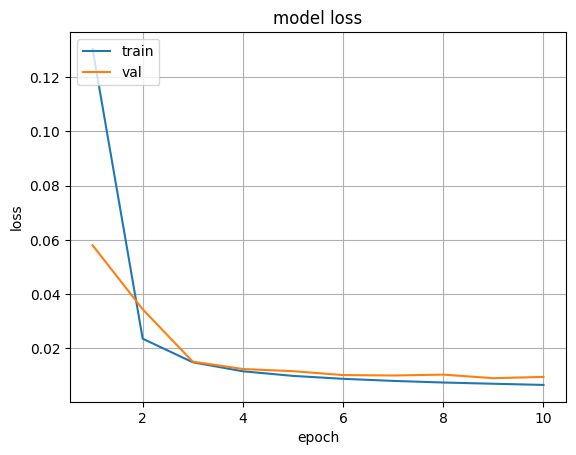

In [ ]:
x_range = np.arange(1, epochs + 1)

plt.plot(x_range, history['train_loss'], label='train')
plt.plot(x_range, history['val_loss'], label='val')

# plt.xticks(np.arange(1, len(history['train_loss'])+1, step=step))
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

# Отображение графика
plt.show()

Сохранение модели

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model1.pth')

# Расчёт метрик для оценки моделей

In [ ]:
# state_dict = torch.load('/content/drive/MyDrive/Сегментация печени/model4.pth', map_location=device)
# model = smp.DeepLabV3Plus(classes=1, in_channels=1)
# model.load_state_dict(state_dict)
# model.to(device)
# model.eval()

## Расчёт индекса Жакара

In [ ]:
def calculate_jaccard_index(pred, gt):
    intersection = torch.logical_and(gt, pred).sum().item()
    union = torch.logical_or(gt, pred).sum().item()
    if union == 0:
      return 1.0 if intersection == 0 else 0.0
    return intersection / union

jaccard_indices = []
for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(images)
    # preds = torch.argmax(outputs, dim=1)
    preds = torch.sigmoid(outputs) > 0.5
    for pred, gt in zip(preds, targets):
        jaccard_index = calculate_jaccard_index(pred, gt)
        jaccard_indices.append(jaccard_index)
average_jaccard_index = np.mean(jaccard_indices)
print("Индекс Жакара:", round(average_jaccard_index, 2))

Индекс Жакара: 0.91


## Расчёт IoU

In [ ]:
def calculate_iou(pred, gt):
    tp, fp, fn = 0, 0, 0
    for i in range(len(gt)):
        for j in range(len(gt[0])):
            if gt[i][j] == True and pred[i][j] == True:
                tp += 1
            elif gt[i][j] == False and pred[i][j] == True:
                fp += 1
            elif gt[i][j] == True and pred[i][j] == False:
                fn += 1

    try:
        iou = tp / (tp + fp + fn)
    except ZeroDivisionError:
        return 0
    return iou

In [ ]:
# def calculate_iou_contour(pred, gt):
#     pred_contour = find_contours(pred)
#     gt_contour = find_contours(gt)

#     return calculate_iou(pred_contour, gt_contour)

In [ ]:
iou_full = 0
# iou_contour = 0
counter = 0

for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.sigmoid(outputs) > 0.5
    for pred, gt in zip(preds, targets):
        pred_np = pred.squeeze(0).cpu().numpy().astype(bool)
        gt_np = gt.squeeze(0).cpu().numpy().astype(bool)

        iou_full += calculate_iou(pred_np, gt_np)
        # iou_contour += calculate_iou_contour(pred, gt)
        counter += 1
try:
    iou_avg_full = iou_full / counter
except ZeroDivisionError:
    iou_avg_full = 0

# try:
#     iou_avg_contour = iou_contour / counter
# except ZeroDivisionError:
#     iou_avg_contour = 0

In [ ]:
print(f'IoU полная маска: {round(iou_avg_full, 2)}')
# print(f'IoU контур: {round(iou_avg_contour, 2)}')

IoU полная маска: 0.91


## Коробочный IoU

In [ ]:
from torchvision.ops import box_iou, masks_to_boxes

In [ ]:
iou_box_full = 0
counter = 0

for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.sigmoid(outputs) > 0.5

    if not torch.any(preds):
        iou_box_full += 0
    else:
        pred_boxes = masks_to_boxes(preds.squeeze(1))
        gt_boxes = masks_to_boxes(targets.squeeze(1))
        iou_box_full += box_iou(pred_boxes, gt_boxes).mean().item()

    counter += 1

iou_avg_box_full = iou_box_full / counter if counter > 0 else 0

    # for pred, gt in zip(preds, targets):
    #     pred_np = pred.squeeze(0).cpu().numpy().astype(bool)
    #     gt_np = gt.squeeze(0).cpu().numpy().astype(bool)
    #     iou_box_full += box_iou(pred_np, gt_np)
    #     counter += 1

# try:
#     iou_avg_box_full = iou_box_full / counter
# except ZeroDivisionError:
#     iou_avg_box_full = 0


In [ ]:

print(f'IoU коробочный полная маска: {round(iou_avg_box_full, 2)}')

IoU коробочный полная маска: 0.91


## Результаты

In [ ]:
print("Индекс Жакара:", round(average_jaccard_index, 2))
print(f'IoU полная маска: {round(iou_avg_full, 2)}')
print(f'IoU коробочный полная маска: {round(iou_avg_box_full, 2)}')

Индекс Жакара: 0.91
IoU полная маска: 0.91
IoU коробочный полная маска: 0.91


# Визуализация оригинального изображения GT-маски и предсказанной маски

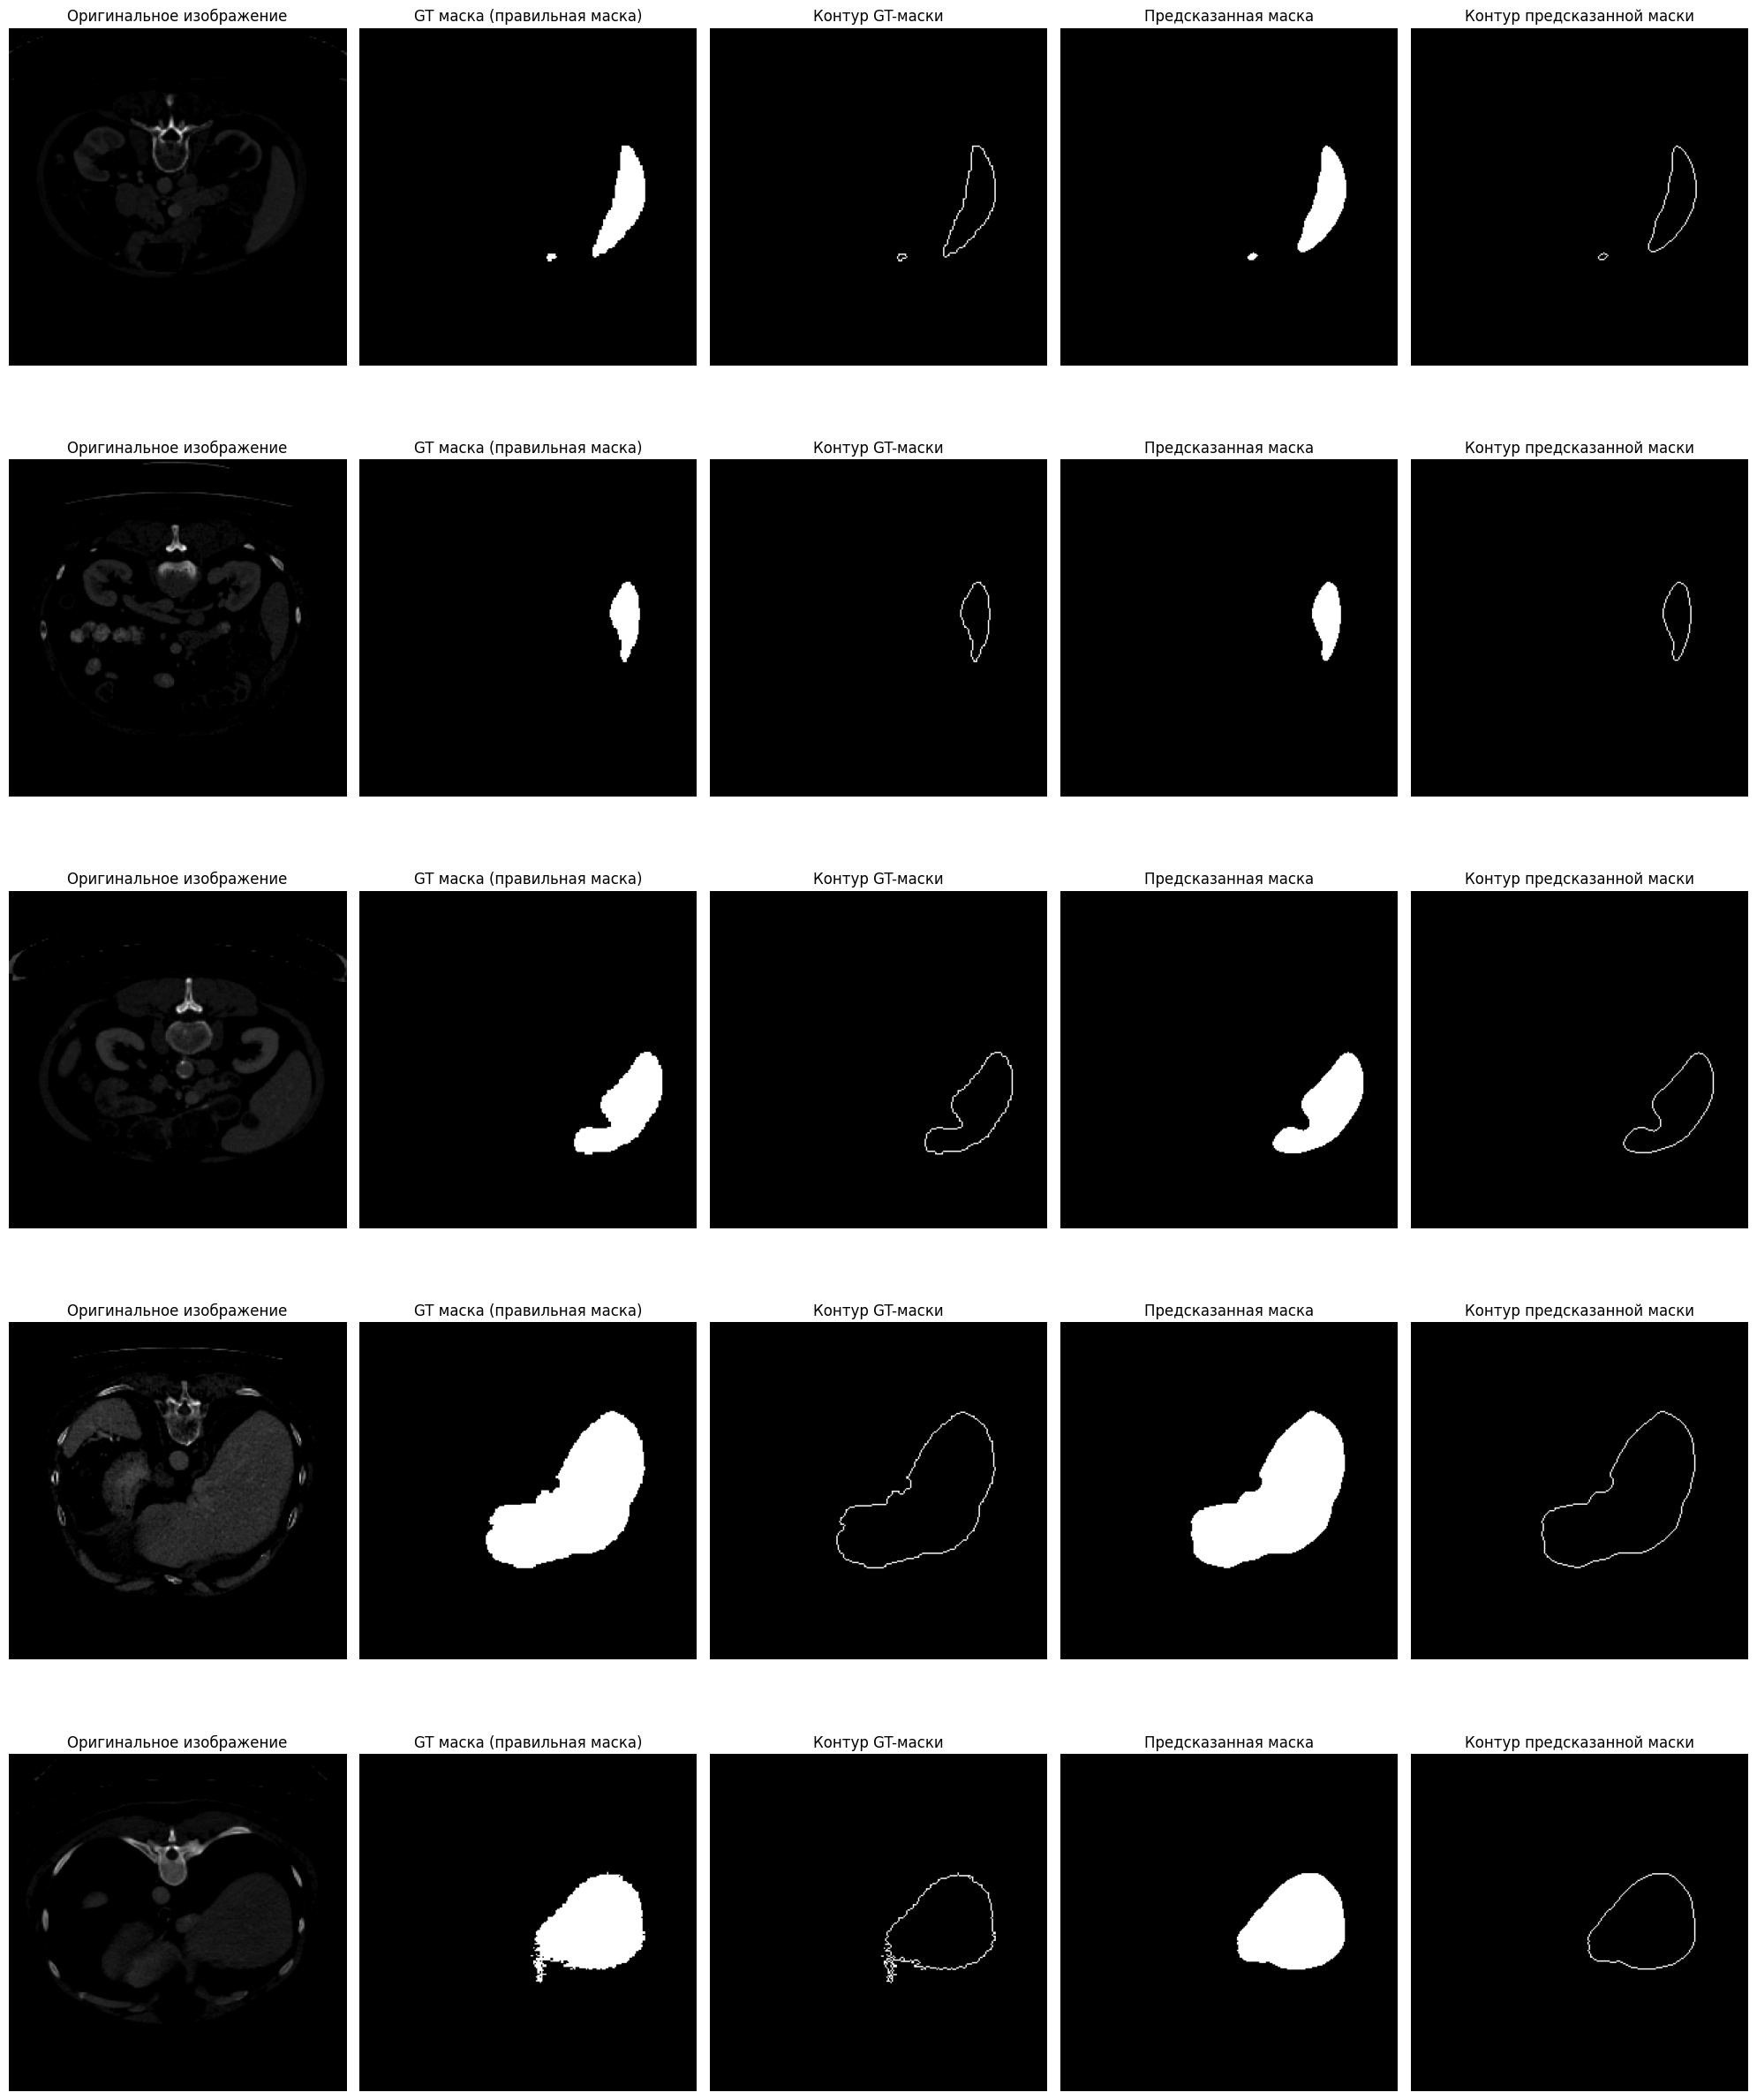

In [ ]:
visualize_dataset(test_dl, num_images=5, model=model)